# Catching close encounters using exceptions
Sometimes one is interested in catching a close encounter between two planets. This can easily be done with REBOUND. What you do when a close encounter happens is up to you.

Some integrators are better suited to simulate close encounters than others. For example, the non-symplectic integrator IAS15 has an adaptive timestep scheme that resolves close encounters very well. Integrators that use a fixed timestep like WHFast are more likely to miss close encounters.

Let's start with a two-planet system that will go unstable on a short timescale:

In [1]:
import rebound
import numpy as np
def setupSimulation():
    rebound.reset()
    rebound.integrator = "ias15" # IAS15 is the default integrator, so we don't need this line
    rebound.add(m=1.)
    rebound.add(m=1e-3,a=1.)
    rebound.add(m=5e-3,a=1.25)
    rebound.move_to_com()

Let's integrate this system for 100 orbital periods.

In [2]:
setupSimulation()
rebound.integrate(100.*2.*np.pi)

Rebound exits the integration routine normally. We can now explore the final particle orbits:

In [3]:
for o in rebound.calculate_orbits():
    print(o)

<rebound.Orbit instance, a=4.818275184875015 e=0.719825680767194>
<rebound.Orbit instance, a=1.042152516577048 e=0.12277280459654771>


We see that the orbits of both planets changed significantly and we can already speculate that there was a close encounter.

Let's redo the simulation, but this time set the `minD` flag in the integrate routine. If this flag is set, then REBOUND calculates the minimum distance between any two particle pairs. If the distance is less than `minD`, then the integration is stopped and an exception thrown. The [Hill radius](http://en.wikipedia.org/wiki/Hill_sphere) is given by $r_{\rm Hill} \approx a \sqrt{\frac{m}{3M}}$ which is approximately 0.15 AU in our case. 

If we simply set the breakout flag `minD` when we call `rebound.integrate`, and there's a close encounter, the program will crash due to an unhandled exception.  This setup allows us to instead catch the exception and deal with it in a customized way.  As a first example, let's catch the exception with a `try`-`except` block, and simply print out information about the close encounter, and let's set `minD` to roughly one Hill radius.  Additionally, let's store the particles' separations while we're integrating:

In [4]:
setupSimulation() # Resets everything
Noutputs = 1000
times = np.linspace(0,100.*2.*np.pi,Noutputs)
distances = np.zeros(Noutputs)
ps = rebound.particles # ps is now an array of pointers. It will update as the simulation runs.
try:
    for i,time in enumerate(times):
        rebound.integrate(time,minD=0.15)
        dx = ps[1].x - ps[2].x
        dy = ps[1].y - ps[2].y
        dz = ps[1].z - ps[2].z
        distances[i] = np.sqrt(dx*dx+dy*dy+dz*dz)
except rebound.CloseEncounter as error:
    print(error)

A close encounter occured at time 28.774871 between particles with IDs 2 and 1.


Let plot the distance as a function of time.

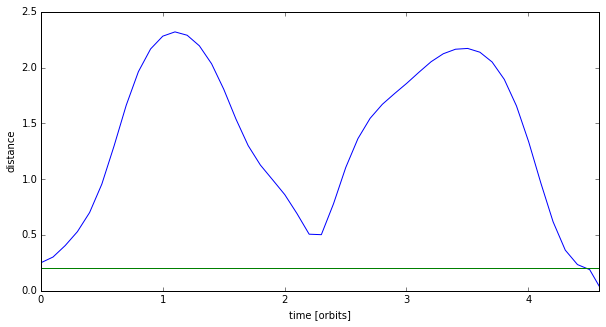

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.set_xlabel("time [orbits]")
ax.set_xlim([0,rebound.t/(2.*np.pi)])
ax.set_ylabel("distance")
plt.plot(times/(2.*np.pi), distances);
plt.plot([0.0,12],[0.2,0.2]) # Plot our close encounter criteria;

We did indeed find the close enounter correctly. We could now do something with the two particles that collided. 

Let's to the simplest thing, let's merge them. To do that we'll first calculate our new merged planet coordinates, then clear all particles from REBOUND and finally add the new particles.  Here we also choose to assign the new merged body the ID of the larger-mass particle.

In [9]:
import copy
def mergeParticles(i1,i2):
    old_ps = rebound.particles
    new_ps = []
    for i in range(rebound.N):
        if i!=i1 and i!=i2:
            new_ps.append(copy.deepcopy(old_ps[i]))        
    mergedPlanet = rebound.Particle()
    mergedPlanet.m  = old_ps[i1].m + old_ps[i2].m
    mergedPlanet.x  = (old_ps[i1].m*old_ps[i1].x  + old_ps[i2].m*old_ps[i2].x) /mergedPlanet.m
    mergedPlanet.y  = (old_ps[i1].m*old_ps[i1].y  + old_ps[i2].m*old_ps[i2].y) /mergedPlanet.m
    mergedPlanet.z  = (old_ps[i1].m*old_ps[i1].z  + old_ps[i2].m*old_ps[i2].z) /mergedPlanet.m
    mergedPlanet.vx = (old_ps[i1].m*old_ps[i1].vx + old_ps[i2].m*old_ps[i2].vx)/mergedPlanet.m
    mergedPlanet.vy = (old_ps[i1].m*old_ps[i1].vy + old_ps[i2].m*old_ps[i2].vy)/mergedPlanet.m
    mergedPlanet.vz = (old_ps[i1].m*old_ps[i1].vz + old_ps[i2].m*old_ps[i2].vz)/mergedPlanet.m
    mergedPlanet.ID = old_ps[i1].ID if old_ps[i1].m > old_ps[i2].m else old_ps[i2].ID # give ID of higher mass body
    new_ps.append(mergedPlanet)
    del(rebound.particles)
    rebound.add(new_ps)

setupSimulation() # Resets everything
print("Number of particles at the beginning of the simulation: %d."%rebound.N)
for i,time in enumerate(times):
    try:
        rebound.integrate(time,minD=0.2)
    except rebound.CloseEncounter as error:
        print(error)
        mergeParticles(error.index1,error.index2)
print("ID of merged particle: %d."%rebound.particles[-1].ID)
print("Number of particles at the end of the simulation: %d."%rebound.N)

Number of particles at the beginning of the simulation: 3.
A close encounter occured at time 28.156505 between particles with IDs 2 and 1.
ID of merged particle: 2.
Number of particles at the end of the simulation: 2.
